In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [26]:
class MulticlassConfig:
    """Configuration for multiclass malware detection"""
    def __init__(self):
        # Model
        self.hidden_size = 128
        self.dropout = 0.3
        
        # Training
        self.batch_size = 32
        self.epochs = 20
        self.learning_rate = 0.001
        
        # Data
        self.max_length = 80
        self.num_classes = 6  # adware, ransomware, rootkit, trojan, coinminer, keylogger
        
        # Device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MalwareDataset(Dataset):
    def __init__(self, sequences, numeric_features, labels, vocab, max_length):
        self.sequences = sequences
        self.numeric_features = numeric_features
        self.labels = labels
        self.max_length = max_length
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        if isinstance(seq, str) and seq:
            tokens = seq.split(';')
            indices = [self.vocab.get(token, 1) for token in tokens]
        else:
            indices = []
        
        # Pad or truncate
        if len(indices) > self.max_length:
            indices = indices[:self.max_length]
        else:
            indices += [0] * (self.max_length - len(indices))
        
        return {
            'sequence': torch.tensor(indices, dtype=torch.long),
            'numeric': torch.tensor(self.numeric_features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [28]:
class MulticlassBiLSTM(nn.Module):
    def __init__(self, vocab_size, config):
        super(MulticlassBiLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, 64, padding_idx=0)
        self.lstm = nn.LSTM(64, config.hidden_size, batch_first=True, bidirectional=True)
        
        # Simple classifier
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size * 2 + 4, 64),  # +4 for numeric features
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(64, 6)
        )
        
    def forward(self, sequence, numeric):
        embedded = self.embedding(sequence)
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Use last hidden state
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        
        # Combine features
        combined = torch.cat((hidden, numeric), dim=1)
        output = self.classifier(combined)
        
        return output


In [29]:
class MulticlassMalwareDetector:
    """Multiclass malware detector"""
    def __init__(self, config=None):
        self.config = config or MulticlassConfig()
        self.vocab = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.model = None
        self.class_names = ['adware', 'ransomware', 'rootkit', 'trojan', 'coinminer', 'keylogger']
        
    def load_vocab_and_scaler(self):
        """Load existing vocabulary and scaler from model folder"""
        try:
            # Load vocabulary
            with open('model/vocab.pkl', 'rb') as f:
                self.vocab = pickle.load(f)
            print(f"✅ Loaded vocabulary with {len(self.vocab)} tokens")
            
            # Load scaler
            self.scaler = joblib.load('model/scaler.pkl')
            print("✅ Loaded scaler from model folder")
            
            return True
        except FileNotFoundError as e:
            print(f"❌ Error loading from model folder: {e}")
            print("Please ensure vocab.pkl and scaler.pkl exist in the model folder")
            return False
    
    def prepare_multiclass_data(self, csv_files):
        """Prepare data for multiclass classification"""
        all_dfs = []
        
        # Load all CSV files
        for class_name, csv_file in csv_files.items():
            try:
                df = pd.read_csv(csv_file)
                df['malware_type'] = class_name
                all_dfs.append(df)
                print(f"Loaded {len(df)} samples from {csv_file} ({class_name})")
            except FileNotFoundError:
                print(f"⚠️  Warning: {csv_file} not found, skipping {class_name}")
        
        if not all_dfs:
            raise ValueError("No CSV files could be loaded!")
        
        # Combine all data
        df = pd.concat(all_dfs, ignore_index=True)
        print(f"Total samples: {len(df)}")
        
        # Combine sequence features
        sequence_cols = ['exec_processes_seq', 'exec_paths_seq', 'dns_queries_seq', 
                        'udp_ports_seq', 'hosts_seq', 'sig_names_seq']
        
        sequences = []
        for _, row in df.iterrows():
            parts = [str(row[col]) for col in sequence_cols if pd.notna(row[col]) and row[col] and str(row[col]) != 'nan']
            sequences.append(';'.join(parts))
        
        # Numeric features
        numeric_cols = ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets']
        numeric_features = df[numeric_cols].fillna(0).values
        
        # Encode labels
        labels = self.label_encoder.fit_transform(df['malware_type'].values)
        
        # Print class distribution
        print("\n📊 Class Distribution:")
        for i, class_name in enumerate(self.label_encoder.classes_):
            count = np.sum(labels == i)
            print(f"  {class_name}: {count} samples ({count/len(labels)*100:.1f}%)")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            list(zip(sequences, numeric_features)), labels, 
            test_size=0.2, random_state=42, stratify=labels
        )
        
        # Process features
        train_seq, train_num = zip(*X_train)
        test_seq, test_num = zip(*X_test)
        
        # Scale numeric features using existing scaler
        train_num = self.scaler.transform(np.array(train_num))
        test_num = self.scaler.transform(np.array(test_num))
        
        # Create datasets
        train_dataset = MalwareMulticlassDataset(train_seq, train_num, y_train, self.vocab, self.config.max_length)
        test_dataset = MalwareMulticlassDataset(test_seq, test_num, y_test, self.vocab, self.config.max_length)
        
        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.config.batch_size, shuffle=False)
        
        return train_loader, test_loader
    
    def train(self, train_loader, test_loader):
        """Training loop for multiclass model"""
        self.model = MulticlassBiLSTM(len(self.vocab), self.config).to(self.config.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)
        
        print(f"\n🚀 Training multiclass model for {self.config.epochs} epochs on {self.config.device}...")
        
        best_acc = 0
        for epoch in range(self.config.epochs):
            # Training
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch in train_loader:
                seq = batch['sequence'].to(self.config.device)
                num = batch['numeric'].to(self.config.device)
                labels = batch['label'].to(self.config.device)
                
                optimizer.zero_grad()
                outputs = self.model(seq, num)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
            
            # Validation
            val_acc = self.quick_evaluate(test_loader)
            
            train_acc = 100. * train_correct / train_total
            print(f"Epoch {epoch+1:2d}/{self.config.epochs} | "
                  f"Train: {train_acc:5.1f}% | Val: {val_acc:5.1f}%")
            
            # Save best model
            if val_acc > best_acc:
                best_acc = val_acc
                self.save_multiclass_model()
        
        print(f"✅ Training completed! Best accuracy: {best_acc:.1f}%")
    
    def quick_evaluate(self, test_loader):
        """Quick evaluation during training"""
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                seq = batch['sequence'].to(self.config.device)
                num = batch['numeric'].to(self.config.device)
                labels = batch['label'].to(self.config.device)
                
                outputs = self.model(seq, num)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return 100. * correct / total
    
    def evaluate_multiclass(self, test_loader):
        """Detailed multiclass evaluation"""
        self.model.eval()
        all_predictions = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch in test_loader:
                seq = batch['sequence'].to(self.config.device)
                num = batch['numeric'].to(self.config.device)
                labels = batch['label'].to(self.config.device)
                
                outputs = self.model(seq, num)
                probs = torch.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        
        # Get class names for reports
        class_names = self.label_encoder.classes_
        
        print("=" * 70)
        print("📊 MULTICLASS MALWARE DETECTION RESULTS")
        print("=" * 70)
        print(f"🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
        
        # Sample predictions
        print(f"\n🔍 Sample Predictions:")
        print(f"{'Sample':<8} {'True':<12} {'Predicted':<12} {'Confidence':<12}")
        print("-" * 50)
        
        for i in range(min(15, len(all_labels))):
            true_class = class_names[all_labels[i]]
            pred_class = class_names[all_predictions[i]]
            confidence = np.max(all_probs[i])
            
            print(f"{i+1:<8} {true_class:<12} {pred_class:<12} {confidence:<12.3f}")
        
        # Classification report
        print(f"\n📋 Detailed Classification Report:")
        report = classification_report(all_labels, all_predictions, 
                                     target_names=class_names, 
                                     digits=3, output_dict=True)
        
        print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
        print("-" * 62)
        
        for class_name in class_names:
            metrics = report[class_name]
            print(f"{class_name:<12} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} {metrics['f1-score']:<10.3f} {metrics['support']:<10.0f}")
        
        print("-" * 62)
        print(f"{'Accuracy':<12} {'':<10} {'':<10} {report['accuracy']:<10.3f} {report['macro avg']['support']:<10.0f}")
        print(f"{'Macro Avg':<12} {report['macro avg']['precision']:<10.3f} {report['macro avg']['recall']:<10.3f} {report['macro avg']['f1-score']:<10.3f} {report['macro avg']['support']:<10.0f}")
        print(f"{'Weighted Avg':<12} {report['weighted avg']['precision']:<10.3f} {report['weighted avg']['recall']:<10.3f} {report['weighted avg']['f1-score']:<10.3f} {report['weighted avg']['support']:<10.0f}")
        
        print("=" * 70)
        
        # Confusion matrix
        self.plot_confusion_matrix(all_labels, all_predictions, class_names)
        
        return {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(all_labels, all_predictions),
            'class_names': class_names
        }
    
    def plot_confusion_matrix(self, true_labels, pred_labels, class_names):
        """Plot confusion matrix"""
        cm = confusion_matrix(true_labels, pred_labels)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix - Multiclass Malware Detection')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        plt.savefig('multiclass_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("📈 Confusion matrix saved as 'multiclass_confusion_matrix.png'")
    
    def predict_multiclass_sample(self, sequence, numeric_features, confidence_threshold=0.7):
        """Predict single sample for multiclass with 'other' category"""
        self.model.eval()
        
        # Process sequence
        if isinstance(sequence, str) and sequence:
            tokens = sequence.split(';')
            indices = [self.vocab.get(token, 1) for token in tokens]
        else:
            indices = []
        
        # Pad/truncate
        if len(indices) > self.config.max_length:
            indices = indices[:self.config.max_length]
        else:
            indices += [0] * (self.config.max_length - len(indices))
        
        # Convert to tensors
        seq_tensor = torch.tensor([indices], dtype=torch.long).to(self.config.device)
        num_tensor = torch.tensor([numeric_features], dtype=torch.float32).to(self.config.device)
        
        with torch.no_grad():
            outputs = self.model(seq_tensor, num_tensor)
            probs = torch.softmax(outputs, dim=1)
            
            predicted_class = torch.argmax(probs, dim=1).item()
            confidence = torch.max(probs, dim=1)[0].item()
            max_prob = torch.max(probs, dim=1)[0].item()
            
            # Check if confidence is below threshold → classify as "other"
            if confidence < confidence_threshold:
                class_name = "other"
                predicted_class = -1  # Special code for "other"
            else:
                class_name = self.label_encoder.classes_[predicted_class]
            
            # Get probabilities for all classes
            class_probs = {}
            for i, class_name_i in enumerate(self.label_encoder.classes_):
                class_probs[class_name_i] = probs[0, i].item()
        
        return {
            'predicted_class': predicted_class,
            'class_name': class_name,
            'confidence': confidence,
            'max_probability': max_prob,
            'is_other': confidence < confidence_threshold,
            'class_probabilities': class_probs,
            'threshold_used': confidence_threshold
        }
    
    def save_multiclass_model(self):
        """Save multiclass model and artifacts"""
        os.makedirs('model_multiclass', exist_ok=True)
        
        # Save model
        torch.save(self.model.state_dict(), 'model_multiclass/multiclass_bilstm.pth')
        
        # Save label encoder
        joblib.dump(self.label_encoder, 'model_multiclass/label_encoder.pkl')
        
        # Save config
        config_dict = {
            'hidden_size': self.config.hidden_size,
            'dropout': self.config.dropout,
            'max_length': self.config.max_length,
            'num_classes': self.config.num_classes
        }
        with open('model_multiclass/config.pkl', 'wb') as f:
            pickle.dump(config_dict, f)
        
        print("💾 Multiclass model saved to 'model_multiclass/' folder")
    
    def run_multiclass(self, csv_files):
        """Complete multiclass pipeline"""
        print("🚀 BiLSTM Multiclass Malware Detector")
        
        # Load existing vocab and scaler
        if not self.load_vocab_and_scaler():
            return None
        
        # Prepare data
        train_loader, test_loader = self.prepare_multiclass_data(csv_files)
        
        # Train model
        self.train(train_loader, test_loader)
        
        # Load best model
        self.model.load_state_dict(torch.load('model_multiclass/multiclass_bilstm.pth', 
                                             map_location=self.config.device))
        
        # Evaluate
        results = self.evaluate_multiclass(test_loader)
        
        return results

🚀 BiLSTM Multiclass Malware Detector
✅ Loaded vocabulary with 2368 tokens
✅ Loaded scaler from model folder
Loaded 99 samples from fitur_adware.csv (adware)
Loaded 104 samples from fitur_Ransomware.csv (ransomware)
Loaded 34 samples from fitur_Rootkit.csv (rootkit)
Loaded 101 samples from fitur_trojan.csv (trojan)
Loaded 113 samples from fitur_coinminer.csv (coinminer)
Loaded 100 samples from fitur_Keylogger.csv (keylogger)
Total samples: 551

📊 Class Distribution:
  adware: 99 samples (18.0%)
  coinminer: 113 samples (20.5%)
  keylogger: 100 samples (18.1%)
  ransomware: 104 samples (18.9%)
  rootkit: 34 samples (6.2%)
  trojan: 101 samples (18.3%)

🚀 Training multiclass model for 25 epochs on cpu...
Epoch  1/25 | Train:  30.9% | Val:  44.1%
💾 Multiclass model saved to 'model_multiclass/' folder
Epoch  2/25 | Train:  39.8% | Val:  41.4%
Epoch  3/25 | Train:  40.0% | Val:  47.7%
💾 Multiclass model saved to 'model_multiclass/' folder
Epoch  4/25 | Train:  43.9% | Val:  45.9%
Epoch  5/25

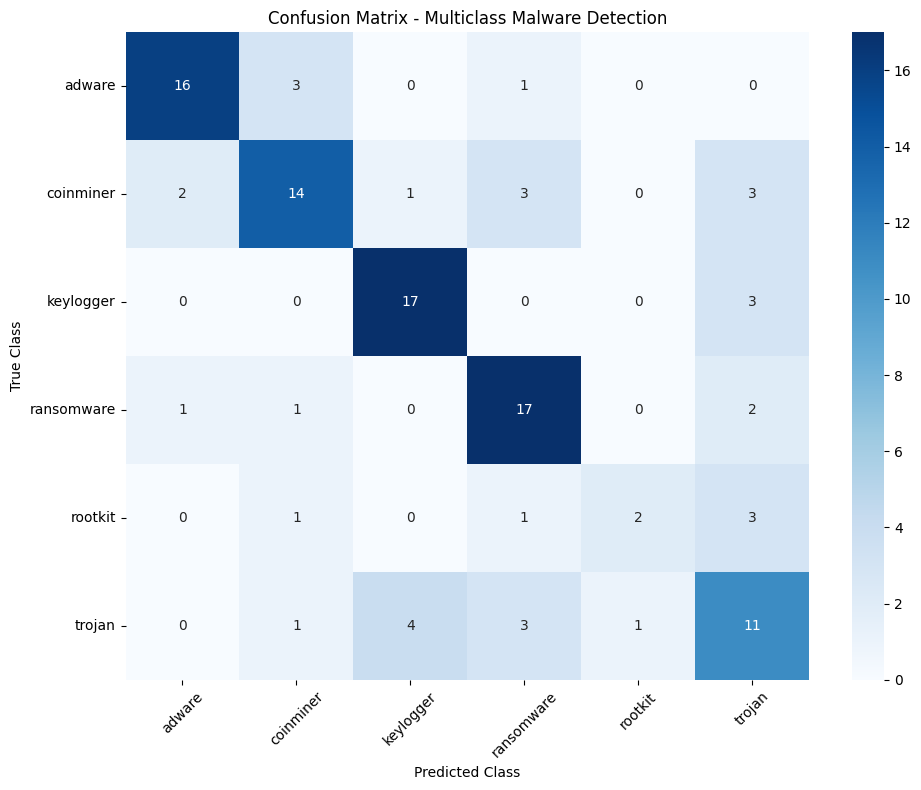

📈 Confusion matrix saved as 'multiclass_confusion_matrix.png'

🎯 Multiclass Summary:
   Overall Accuracy: 0.694
   adware F1-Score: 0.821
   coinminer F1-Score: 0.651
   keylogger F1-Score: 0.810
   ransomware F1-Score: 0.739
   rootkit F1-Score: 0.400
   trojan F1-Score: 0.524

🔍 Example Multiclass Prediction with 'Other' Category:

📊 Threshold: 0.5
   Predicted Class: ransomware
   Confidence: 0.589
   Is Other: False
   Top 3 probabilities:
     ransomware: 0.589
     coinminer: 0.254
     adware: 0.089

📊 Threshold: 0.7
   Predicted Class: other
   Confidence: 0.589
   Is Other: True

📊 Threshold: 0.9
   Predicted Class: other
   Confidence: 0.589
   Is Other: True


In [30]:
def train_multiclass(epochs=20, hidden_size=128):
    """Train multiclass malware detector"""
    
    # Define CSV files for each malware type
    csv_files = {
        'adware': 'fitur_adware.csv',
        'ransomware': 'fitur_Ransomware.csv',
        'rootkit': 'fitur_Rootkit.csv',
        'trojan': 'fitur_trojan.csv',
        'coinminer': 'fitur_coinminer.csv',
        'keylogger': 'fitur_Keylogger.csv'
    }
    
    config = MulticlassConfig()
    config.epochs = epochs
    config.hidden_size = hidden_size
    
    detector = MulticlassMalwareDetector(config)
    results = detector.run_multiclass(csv_files)
    
    if results:
        print(f"\n🎯 Multiclass Summary:")
        print(f"   Overall Accuracy: {results['accuracy']:.3f}")
        
        # Show per-class F1 scores
        report = results['classification_report']
        for class_name in results['class_names']:
            f1_score = report[class_name]['f1-score']
            print(f"   {class_name} F1-Score: {f1_score:.3f}")
    
    return detector, results

# Example usage
if __name__ == "__main__":
    detector, results = train_multiclass(epochs=25)
    
    if detector and results:
        # Example multiclass prediction with "other" category
        print("\n🔍 Example Multiclass Prediction with 'Other' Category:")
        sample_seq = "calc.exe;cmd.exe;powershell.exe"
        sample_numeric = [3, 2, 8, 5]  # num_execs, num_unique_execs, num_dns_queries, num_udp_packets
        
        # Test with different thresholds
        for threshold in [0.5, 0.7, 0.9]:
            result = detector.predict_multiclass_sample(sample_seq, sample_numeric, confidence_threshold=threshold)
            print(f"\n📊 Threshold: {threshold}")
            print(f"   Predicted Class: {result['class_name']}")
            print(f"   Confidence: {result['confidence']:.3f}")
            print(f"   Is Other: {result['is_other']}")
            if not result['is_other']:
                print(f"   Top 3 probabilities:")
                sorted_probs = sorted(result['class_probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
                for class_name, prob in sorted_probs:
                    print(f"     {class_name}: {prob:.3f}")